# BERT Fine-Tuning

Use of BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification.


# 1. Setup

In [2]:
!nvidia-smi

Wed May 31 18:16:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8                4W /  N/A|    569MiB /  4096MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# import tensorflow as tf
import torch

## Installing the Hugging Face Library


In [4]:
!pip install transformers
# !pip install wget

In [5]:
import os
import time
# import wget
import logging
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
# from keras.utils import pad_sequences

import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

c:\Users\ADAWAS\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """
    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")
      
set_seed(2023)

In [7]:
# =============================================================================
# ## check GPU
# =============================================================================
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1650


# 2. Loading Dataset


we going to use sentiment data from US airline for sentiment analysis

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


## Download & Extract

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [8]:
url = r'https://raw.githubusercontent.com/PRIMEADAWAS/Python101/main/Pytorch101/mtsamples.csv'
# url = r"../input/medicaltranscriptions/mtsamples.csv"

In [9]:
# import dataset
df = pd.read_csv(url)[['transcription', 'medical_specialty']]
df['medical_specialty'] = df['medical_specialty'].str.strip()

labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['medical_specialty'])

# df = df.head(1000)
print('Downloading dataset...')
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 4,999



,transcription,medical_specialty,label
3006,"PREOPERATIVE DIAGNOSIS: ,Right ureteropelvic ...",Nephrology,21
3408,"ADMITTING DIAGNOSES:,1. Bradycardia.,2. Dizz...",General Medicine,15
3388,"CHIEF COMPLAINT:, ""I took Ecstasy."",HISTORY O...",General Medicine,15
1796,"REASON FOR REFERRAL:, The patient is a 76-yea...",Psychiatry / Psychology,32
3696,"PREOPERATIVE DIAGNOSES:,1. Ventilator-depende...",ENT - Otolaryngology,11
2453,"SUBJECTIVE:, A 6-year-old boy who underwent t...",Office Notes,25
3039,"EXAM: , CT pelvis with contrast and ct abdomen...",Nephrology,21
1289,"HISTORY OF PRESENT ILLNESS:, Ms. Connor is a ...",SOAP / Chart / Progress Notes,35
4637,"PREOPERATIVE DIAGNOSIS: , Thrombosed arteriove...",Cardiovascular / Pulmonary,3
1384,"SUBJECTIVE:, The patient is a 7-year-old male...",SOAP / Chart / Progress Notes,35


In [10]:
len(labelencoder.classes_), labelencoder.classes_

(40,
 array(['Allergy / Immunology', 'Autopsy', 'Bariatrics',
        'Cardiovascular / Pulmonary', 'Chiropractic',
        'Consult - History and Phy.', 'Cosmetic / Plastic Surgery',
        'Dentistry', 'Dermatology', 'Diets and Nutritions',
        'Discharge Summary', 'ENT - Otolaryngology',
        'Emergency Room Reports', 'Endocrinology', 'Gastroenterology',
        'General Medicine', 'Hematology - Oncology',
        'Hospice - Palliative Care', 'IME-QME-Work Comp etc.',
        'Lab Medicine - Pathology', 'Letters', 'Nephrology', 'Neurology',
        'Neurosurgery', 'Obstetrics / Gynecology', 'Office Notes',
        'Ophthalmology', 'Orthopedic', 'Pain Management',
        'Pediatrics - Neonatal', 'Physical Medicine - Rehab', 'Podiatry',
        'Psychiatry / Psychology', 'Radiology', 'Rheumatology',
        'SOAP / Chart / Progress Notes', 'Sleep Medicine',
        'Speech - Language', 'Surgery', 'Urology'], dtype=object))

The two properties we actually care about are the the `text` and its `label`, which is referred to as the (0=negative, 1=neutral, 2=positive).

Here are five sentences which are labeled as not grammatically acceptible. Note how much more difficult this task is than something like sentiment analysis!

In [11]:
df = df.dropna().reset_index(drop=True)

## Class distribution 


In [12]:
def showClass():
  print('Total classes : ',df['medical_specialty'].nunique())
  plt.figure(figsize=(8,8))
  sns.countplot(y='medical_specialty', 
                data = df, 
                order = df['medical_specialty'].value_counts().index)
  plt.show()

Total classes :  40


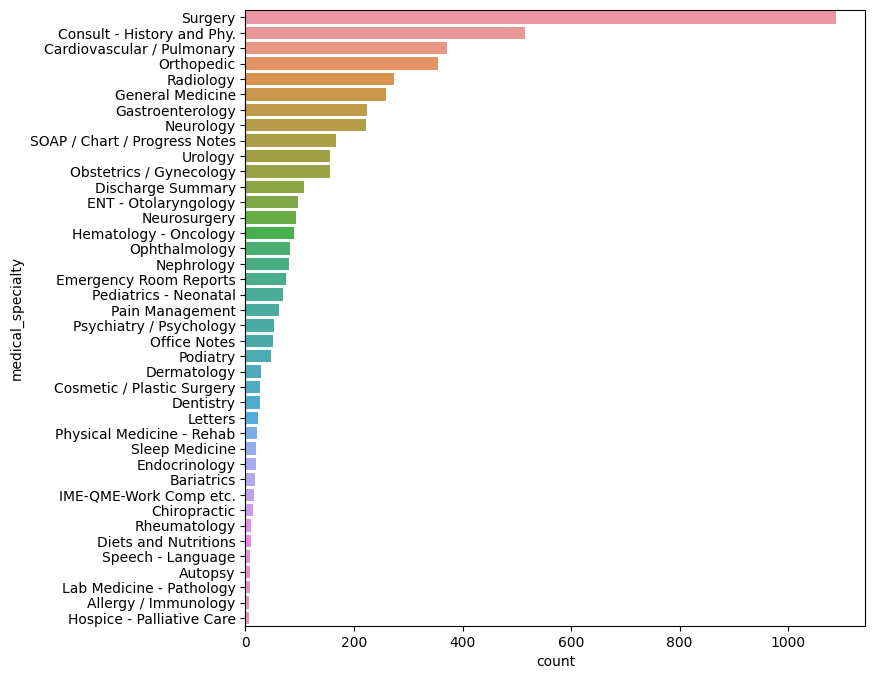

In [13]:
showClass()

In [14]:
df['medical_specialty'].unique()

array(['Allergy / Immunology', 'Bariatrics', 'Cardiovascular / Pulmonary',
       'Neurology', 'Dentistry', 'Urology', 'General Medicine', 'Surgery',
       'Speech - Language', 'SOAP / Chart / Progress Notes',
       'Sleep Medicine', 'Rheumatology', 'Radiology',
       'Psychiatry / Psychology', 'Podiatry', 'Physical Medicine - Rehab',
       'Pediatrics - Neonatal', 'Pain Management', 'Orthopedic',
       'Ophthalmology', 'Office Notes', 'Obstetrics / Gynecology',
       'Neurosurgery', 'Nephrology', 'Letters',
       'Lab Medicine - Pathology', 'IME-QME-Work Comp etc.',
       'Hospice - Palliative Care', 'Hematology - Oncology',
       'Gastroenterology', 'ENT - Otolaryngology', 'Endocrinology',
       'Emergency Room Reports', 'Discharge Summary',
       'Diets and Nutritions', 'Dermatology',
       'Cosmetic / Plastic Surgery', 'Consult - History and Phy.',
       'Chiropractic', 'Autopsy'], dtype=object)

remove non-medical specialty class

In [15]:
exclusion_list = ['SOAP / Chart / Progress Notes', 'Consult - History exclusion_listnd Phy.', 'Office Notes', 'Letters', 'Lab Medicine - Pathology', 'IME-QME-Work Comp etc.', 'Hospice - Palliative Care', 'Discharge Summary', 'Consult - History and Phy.']
df = df[~df['medical_specialty'].isin(exclusion_list)]
df['medical_specialty'].value_counts()

medical_specialty
Surgery                       1088
Cardiovascular / Pulmonary     371
Orthopedic                     355
Radiology                      273
General Medicine               259
Gastroenterology               224
Neurology                      223
Urology                        156
Obstetrics / Gynecology        155
ENT - Otolaryngology            96
Neurosurgery                    94
Hematology - Oncology           90
Ophthalmology                   83
Nephrology                      81
Emergency Room Reports          75
Pediatrics - Neonatal           70
Pain Management                 61
Psychiatry / Psychology         53
Podiatry                        47
Dermatology                     29
Dentistry                       27
Cosmetic / Plastic Surgery      27
Physical Medicine - Rehab       21
Sleep Medicine                  20
Endocrinology                   19
Bariatrics                      18
Chiropractic                    14
Rheumatology                    10
Di

Change sub minor class to main class

In [16]:
def groupClass(subClass, mainClass):
  df.loc[df.medical_specialty == subClass, "medical_specialty"] = mainClass

In [17]:
for cls in ['Urology', 'Neurosurgery', 'Cosmetic / Plastic Surgery']:
  groupClass(cls, 'Surgery')
for cls in ['Dermatology', 'Endocrinology', 'Rheumatology']:
  groupClass(cls, 'General Medicine')
for cls in ['Pain Management', 'Psychiatry / Psychology', 'Podiatry', 'Dentistry', 'Physical Medicine - Rehab', 'Sleep Medicine', 'Bariatrics', 'Chiropractic', 'Emergency Room Reports', 'Diets and Nutritions', 'Speech - Language', 'Autopsy', 'Allergy / Immunology']:
  groupClass(cls, 'Minor')

Total classes :  14


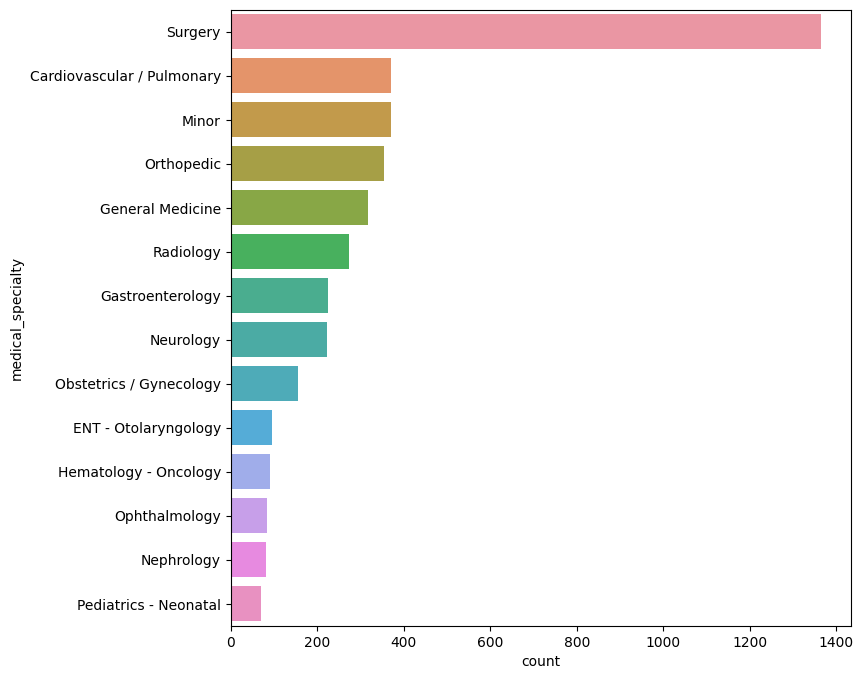

In [18]:
showClass()

In [19]:
df.loc[df['medical_specialty'] == 'Surgery'].sample(5)[['transcription', 'medical_specialty']]

,transcription,medical_specialty
758,"PROCEDURE: , Gastroscopy.,PREOPERATIVE DIAGNOS...",Surgery
623,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...",Surgery
1033,"PREOPERATIVE DIAGNOSIS:, Chest wall mass, lef...",Surgery
934,"PREOPERATIVE DIAGNOSIS:, Residual stone, stat...",Surgery
363,"PREOPERATIVE DIAGNOSIS: , Ruptured globe with ...",Surgery


In [20]:
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['medical_specialty'])
df.sample(5)

,transcription,medical_specialty,label
1744,"REFERRAL QUESTIONS:, Mr. Abcd was referred fo...",Minor,5
164,The patient tolerated the procedure well and w...,Surgery,13
83,"PREOPERATIVE DIAGNOSIS:, Adenocarcinoma of th...",Surgery,13
3612,"OPERATIVE PROCEDURES: , Colonoscopy and biopsi...",Gastroenterology,2
2715,"PREOPERATIVE DIAGNOSES,1. Left neck pain with...",Surgery,13




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [21]:
# Get the lists of sentences and their labels.
# sentences = df.transcription.values
messages = df.transcription.values
labels = df.label.values

In [22]:
# sentences[0], labels[0]

# Preprocessing

## X labels

In [23]:
# messages = df['transcription'].to_numpy()
messages[0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [24]:
import re
from tqdm import tqdm

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens ?
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace URLs with a space in the message
    # text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    # text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    # text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z0-9/\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(message) for message in tqdm(messages)]

100%|██████████| 4073/4073 [00:03<00:00, 1159.91it/s]


In [25]:
preprocessed[0]

'subjective this 23 year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed to lose effectiveness she has used allegra also she used that last summer and she began using it again two weeks ago it does not appear to be working very well she has used over the counter sprays but no prescription nasal sprays she does have asthma but doest not require daily medication for this and does not think it is flaring up medications her only medication currently is ortho tri cyclen and the allegra allergies she has no known medicine allergies objective vitals weight was 130 pounds and blood pressure 124/78 heent her throat was mildly erythematous without exudate nasal mucosa was erythematous and swollen only clear drainage was seen tms were clear neck supple without adenopathy lungs clear assessment allergic rhinitis plan 

## Stopword removal & Lemmatizeration

In [26]:
# !pip install nltk

In [27]:
from collections import Counter
import logging as logger
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option = 4):
  if option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  words = [word for word in word_tokenize(text)]
  # Remove stop words
  stop = set(stopwords.words('english'))
  words = [word for word in words if (word not in stop)]
  # Lemmatize words (first noun, then verb)
  wnl = nltk.stem.WordNetLemmatizer()
  lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
  return lemmatized

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADAWAS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADAWAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADAWAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
sentences = []
for index, message in tqdm(enumerate(preprocessed)):
  tokens = tokenize_text(message)
  new_sentence = ' '.join(tokens)
  sentences.append(new_sentence)

4073it [00:57, 71.07it/s] 


# Create vocab list

In [29]:
# Create vocab
import seaborn as sns
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(preprocessed, True)

Tokenizaing:  74%|███████▍  | 3007/4073 [00:13<00:04, 216.81it/s]


KeyboardInterrupt: 

In [ ]:
len(vocab), list(vocab.keys())[:10]

(20708,
 ['subjective',
  'this',
  'year',
  'old',
  'white',
  'female',
  'presents',
  'with',
  'complaint',
  'of'])

# 3. Data preparation and Tokenization
In this section, we'll transform our dataset into the format that BERT can be trained on.

## BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tokenizers import Tokenizer
url = 'https://github.com/PRIMEADAWAS/CEB_Assignment/blob/main/natural%20language%20processing(NLP)/bert-medical.json'
bert_medical_tokenizer = Tokenizer.from_file(url)

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', tokenizer_object=bert_medical_tokenizer, do_lower_case=True)
# tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', do_lower_case=True)
# bert-base-uncased
# microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext

Loading BERT tokenizer...


In [ ]:
print(tokenizer.tokenize('COVID'))
print(tokenizer.tokenize('hospitalization'))

['cov', '##id']
['hospitalization']


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  subjective 23 year old white female present complaint allergy use allergy live seattle think worse past try claritin zyrtec work short time seem lose effectiveness use allegra also use last summer begin use two week ago appear work well use counter spray prescription nasal spray asthma doest require daily medication think flare medication medication currently ortho tri cyclen allegra allergy know medicine allergy objective vitals weight 130 pound blood pressure 124/78 heent throat mildly erythematous without exudate nasal mucosa erythematous swell clear drainage see tm clear neck supple without adenopathy lung clear assessment allergic rhinitis plan try zyrtec instead allegra another option use loratadine think prescription coverage might cheaper sample nasonex two spray nostril give three week prescription write well
Tokenized:  ['subjective', '23', 'year', 'old', 'white', 'female', 'present', 'complaint', 'allergy', 'use', 'allergy', 'live', 'seattle', 'think', 'worse', '

In [ ]:
# from transformers import AutoModelForMaskedLM, BertForMaskedLM
# modelMLM = BertForMaskedLM.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
# # Let's increase the vocabulary of Bert model and tokenizer
# new_tokens = list(vocab.keys())
# num_added_toks = tokenizer.add_tokens(new_tokens)
# # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.
# modelMLM.resize_token_embeddings(len(tokenizer))
# print(tokenizer.tokenize('COVID'))
# print(tokenizer.tokenize('hospitalization'))

Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  subjective 23 year old white female present complaint allergy use allergy live seattle think worse past try claritin zyrtec work short time seem lose effectiveness use allegra also use last summer begin use two week ago appear work well use counter spray prescription nasal spray asthma doest require daily medication think flare medication medication currently ortho tri cyclen allegra allergy know medicine allergy objective vitals weight 130 pound blood pressure 124/78 heent throat mildly erythematous without exudate nasal mucosa erythematous swell clear drainage see tm clear neck supple without adenopathy lung clear assessment allergic rhinitis plan try zyrtec instead allegra another option use loratadine think prescription coverage might cheaper sample nasonex two spray nostril give three week prescription write well
Tokenized:  ['subjective', '23', 'year', 'old', 'white', 'female', 'present', 'complaint', 'allergy', 'use', 'allergy', 'live', 'seattle', 'think', 'worse', '

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

We are required to:
1. Add special tokens to the `start` and `end` of each sentence.
2. Pad & truncate all sentences to a specific length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

To determine the end of the sentence, will be useful for QA task, we need to append the special `[SEP]` token. 

**`[CLS]`**

For classification tasks, 
the special `[CLS]` token must be added to the beginning of every sentence.

BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.


### Sentence Length & Attention Mask



BERT has two constraints:
1. All sentences must be padded or truncated to a fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
max_len = 512

# # For every sentence...
# for sent in sentences:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# import tqdm for show progression
from tqdm import tqdm
tqdm.pandas()

In [ ]:
def bertTokenizerEncodePlus(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for index, sentence in tqdm(enumerate(sentences)):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence, # Sentence to encode.
                          truncation=True, # Cut word length to maximum 512
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512, # Pad & truncate all sentences.
                          padding='max_length',
                          return_tensors = 'pt' # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

## 3.4. Training & Validation Split


Divide up our training set to use 80% for training and 20% for validation.

In [ ]:
from sklearn.model_selection import train_test_split

sentences = np.array(sentences)
# labels = Y.values

train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size = 0.2, stratify = labels, random_state = 6536115)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size = 0.25, stratify = train_labels, random_state = 6536115)
print(train_sentences.shape, val_sentences.shape, test_sentences.shape)

train_input_ids, train_attention_masks, train_labels = bertTokenizerEncodePlus(train_sentences, train_labels)
val_input_ids, val_attention_masks, val_labels = bertTokenizerEncodePlus(val_sentences, val_labels)
test_input_ids, test_attention_masks, test_labels = bertTokenizerEncodePlus(test_sentences, test_labels)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

(2443,) (815,) (815,)


2443it [00:37, 65.67it/s] 
815it [00:05, 151.73it/s]
815it [00:06, 117.20it/s]


In [ ]:
dc = pd.DataFrame(labels, columns=['labels'])
dc['labels'].value_counts()

13    1365
0      371
5      370
10     355
3      317
12     273
2      224
7      223
8      155
1       96
4       90
9       83
6       81
11      70
Name: labels, dtype: int64

In [ ]:
dc = pd.DataFrame(train_labels, columns=['labels'])
dc['labels'].value_counts()

13    819
0     223
5     222
10    213
3     190
12    163
2     134
7     133
8      93
1      58
4      54
9      50
6      49
11     42
Name: labels, dtype: int64

In [ ]:
dc = pd.DataFrame(val_labels, columns=['labels'])
dc['labels'].value_counts()

13    273
0      74
5      74
10     71
3      64
12     55
2      45
7      45
8      31
1      19
4      18
9      16
6      16
11     14
Name: labels, dtype: int64

In [ ]:
dc = pd.DataFrame(test_labels, columns=['labels'])
dc['labels'].value_counts()

13    273
0      74
5      74
10     71
3      63
12     55
2      45
7      45
8      31
1      19
4      18
9      17
6      16
11     14
Name: labels, dtype: int64

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. Model

### BertModel

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

A variety of NLP tasks already pre-trained can be download from huggingface. 
Here is the current list of classes provided for fine-tuning:
* BertModel



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [ ]:
# Load pre-trained model (weights)
model_wordembedding = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_wordembedding.to(device)
# model_wordembedding.cuda()
model_wordembedding.eval()

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model_wordembedding.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (

### LSTM model

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(torch.nn.Module):
    def __init__(self, embed_dim, hidden_dim, class_num, bidirectional = True):
    # def __init__(self, embed_dim, hidden_dim, n_layers, class_num, dropout, drop_prob, bidirectional = False):
        super(LSTM, self).__init__()

        self.dropout = nn.Dropout(0.2)       
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=self.bidirectional)
        self.fc_one = nn.Linear(hidden_dim, class_num)
        # self.linear = nn.Linear(hidden_dim, class_num)
        self.fc_bi = nn.Linear(hidden_dim*2, class_num)

    def forward(self, x):
        # x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        # print(lstm_out.shape, lstm_out[-1].shape, ht.shape, ht[-1].shape, ct.shape)   
        if  self.bidirectional == True:
          h_bilat = torch.concat([ht[0],ht[-1]],dim=1)   
          # print(h_bilat.shape) 
          return self.fc_bi(h_bilat)
        else:
          return self.fc_one(ht[-1])
    

model = LSTM(embed_dim = 768, hidden_dim = 256, class_num = df['medical_specialty'].nunique())
model.to(device)

LSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
  (fc_one): Linear(in_features=256, out_features=14, bias=True)
  (fc_bi): Linear(in_features=512, out_features=14, bias=True)
)

## 4.2. Loss function, Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 16 (set when creating our DataLoaders)
* Learning rate: 5e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Clear out the gradients in the previous pass. 
- Forward pass
- Backward pass (backpropagation)
- Update parameters with optimizer.step()
- Monitor progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Forward pass
- Compute loss on our validation data
- Monotor progress


Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    # print("preds: ",preds)
    pred_flat = np.argmax(preds, axis=1).flatten()
    # print("pred_flat: ",pred_flat)
    labels_flat = labels.flatten()
    # print("labels_flat: ",labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

We're ready to kick off the training!

In [ ]:
#acculmulate validation accuracy, and timings on stats list.
training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0,epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    
    model_wordembedding.eval() 
    # model_wordembedding.train()

    for step, batch in enumerate(train_dataloader):
        word_embedding = [] # our word embedding input for the actual model
        b_labels = batch[2].type(torch.LongTensor).to(device) # labels (n = batch_size)

        # Progress update every 40 batches.
        if step > 0 and step % 40 == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        ## extract emb from BERT need model.eval and with torch.no_grad()
        for i in range(len(batch[0])):
          # b_input_ids = batch[0][i].to(device)
          # b_input_mask = batch[1][i].to(device)
          b_input_ids = batch[0][i].view(1,len(batch[0][i])).to(device)
          b_input_mask = batch[1][i].view(1,len(batch[1][i])).to(device)
          
          # Run the text through BERT, and collect all of the hidden states produced
          with torch.no_grad():
            # BERT output (n_batch,maxlen,768)
            outputs = model_wordembedding(input_ids = b_input_ids, attention_mask = b_input_mask)
            emb = outputs.last_hidden_state[0]
            word_embedding.append(emb)

        # stack list of sample tensor to batch tensor (batch_size, max_chunk*maxlen, 768)
        word_embedding = torch.stack(word_embedding)   
                
        ## train main model
        # set to train mode
        model.train()

        # reset gradient
        model.zero_grad()
        # enable gradient back from the previous torch.no_grad()
        # with torch.enable_grad():
        out = model(word_embedding)
        loss = loss_fn(out,b_labels)

        total_train_loss += loss

        loss.backward()

        # Clip the norm to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update weight
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # model_wordembedding.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        word_embedding = [] # our word embedding input for the actual model
        b_labels = batch[2].type(torch.LongTensor).to(device) # labels (n = batch_size)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():     
          ## extract emb from BERT need model.eval and with torch.no_grad()
          for i in range(len(batch[0])):
            b_input_ids = batch[0][i].view(1,len(batch[0][i])).to(device)
            b_input_mask = batch[1][i].view(1,len(batch[1][i])).to(device)
            
            # Run the text through BERT, and collect all of the hidden states produced
            outputs = model_wordembedding(input_ids = b_input_ids, attention_mask = b_input_mask)
            # BERT output (n_batch,maxlen,768)
            emb = outputs.last_hidden_state[0]
            word_embedding.append(emb)

        # stack list of sample tensor to batch tensor (batch_size, max_chunk*maxlen, 768)
        word_embedding = torch.stack(word_embedding)   

        # reset gradient
        model.zero_grad()

        # run model
        out = model(word_embedding)
        
        # calculate loss
        loss = loss_fn(out,b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    306.    Elapsed: 0:00:13.
  Batch    80  of    306.    Elapsed: 0:00:24.
  Batch   120  of    306.    Elapsed: 0:00:36.
  Batch   160  of    306.    Elapsed: 0:00:48.
  Batch   200  of    306.    Elapsed: 0:01:00.
  Batch   240  of    306.    Elapsed: 0:01:12.
  Batch   280  of    306.    Elapsed: 0:01:25.

  Average training loss: 2.16
  Training epcoh took: 0:01:34

Running Validation...
  Accuracy: 0.42
  Validation Loss: 1.98
  Validation took: 0:00:32

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    306.    Elapsed: 0:00:14.
  Batch    80  of    306.    Elapsed: 0:00:28.
  Batch   120  of    306.    Elapsed: 0:00:41.
  Batch   160  of    306.    Elapsed: 0:00:55.
  Batch   200  of    306.    Elapsed: 0:01:09.
  Batch   240  of    306.    Elapsed: 0:01:22.
  Batch   280  of    306.    Elapsed: 0:01:36.

  Average training loss: 1.85
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.46
 

Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,"tensor(2.1616, device='cuda:0', grad_fn=<DivBa...","tensor(1.9803, device='cuda:0', grad_fn=<DivBa...",0.421919,0:01:34,0:00:32
2,"tensor(1.8469, device='cuda:0', grad_fn=<DivBa...","tensor(1.7726, device='cuda:0', grad_fn=<DivBa...",0.456232,0:01:45,0:00:33
3,"tensor(1.6769, device='cuda:0', grad_fn=<DivBa...","tensor(1.6790, device='cuda:0', grad_fn=<DivBa...",0.464811,0:01:44,0:00:32
4,"tensor(1.5881, device='cuda:0', grad_fn=<DivBa...","tensor(1.6461, device='cuda:0', grad_fn=<DivBa...",0.480917,0:01:44,0:00:33


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

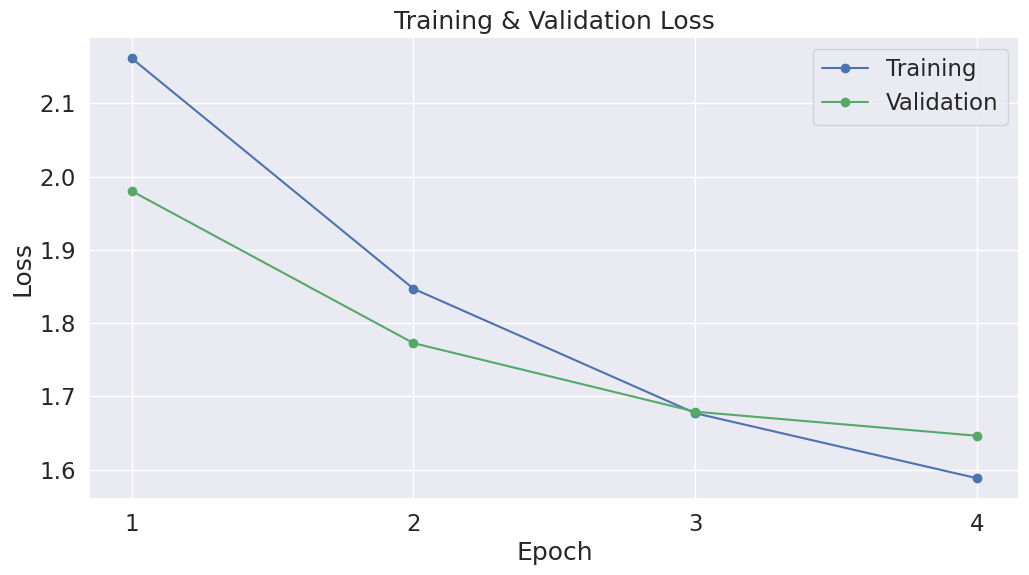

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
model.eval()

In [ ]:
# Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
# model.eval()
model_wordembedding.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  word_embedding = [] # our word embedding input for the actual model
  b_labels = batch[2].type(torch.LongTensor).to(device) # labels (n = batch_size)

  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is only needed for backprop (training).
  with torch.no_grad():     
    ## extract emb from BERT need model.eval and with torch.no_grad()
    for i in range(len(batch[0])):
      b_input_ids = batch[0][i].view(1,len(batch[0][i])).to(device)
      b_input_mask = batch[1][i].view(1,len(batch[1][i])).to(device)
      
      # Run the text through BERT, and collect all of the hidden states produced
      outputs = model_wordembedding(input_ids = b_input_ids, attention_mask = b_input_mask)
      # BERT output (n_batch,maxlen,768)
      emb = outputs.last_hidden_state[0]
      word_embedding.append(emb)

  # stack list of sample tensor to batch tensor (batch_size, max_chunk*maxlen, 768)
  word_embedding = torch.stack(word_embedding)  

  out = model(word_embedding)

  # Move logits and labels to CPU
  logits = out.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

TypeError: ignored

In [ ]:
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_predictions = np.concatenate(predictions, axis=0)

In [ ]:
flat_predictions.shape

(815, 14)

In [ ]:
flat_true_labels.shape

(815,)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

In [ ]:
print('f1 score =',f1_score_func(flat_predictions, flat_true_labels))
print('accuracy score =',flat_accuracy(flat_predictions, flat_true_labels))

f1 score = 0.1884798896974722
accuracy score = 0.43558282208588955


# Result

In [ ]:
flat_predictions = flat_predictions.argmax(1).flatten()

AxisError: ignored

In [ ]:
flat_true_labels[:10]

array([ 4,  3,  2,  1, 10, 12, 10, 11,  3, 13])

In [ ]:
def flat_accuracy(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
print("Accuracy of prediction on test set : ", flat_accuracy(flat_predictions, flat_true_labels))

Accuracy of prediction on test set :  0.43558282208588955


In [ ]:
labelencoder.classes_

array(['Cardiovascular / Pulmonary', 'ENT - Otolaryngology',
       'Gastroenterology', 'General Medicine', 'Hematology - Oncology',
       'Minor', 'Nephrology', 'Neurology', 'Obstetrics / Gynecology',
       'Ophthalmology', 'Orthopedic', 'Pediatrics - Neonatal',
       'Radiology', 'Surgery'], dtype=object)

In [ ]:
label_map = dict(zip(labelencoder.transform(labelencoder.classes_), labelencoder.classes_))
label_map

{0: 'Cardiovascular / Pulmonary',
 1: 'ENT - Otolaryngology',
 2: 'Gastroenterology',
 3: 'General Medicine',
 4: 'Hematology - Oncology',
 5: 'Minor',
 6: 'Nephrology',
 7: 'Neurology',
 8: 'Obstetrics / Gynecology',
 9: 'Ophthalmology',
 10: 'Orthopedic',
 11: 'Pediatrics - Neonatal',
 12: 'Radiology',
 13: 'Surgery'}

In [ ]:
pred_labels = [label_map[i] for i in flat_predictions]
test_labels = [label_map[i] for i in flat_true_labels]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
category_list = list(label_map.values())
cm = confusion_matrix(pred_labels, test_labels)

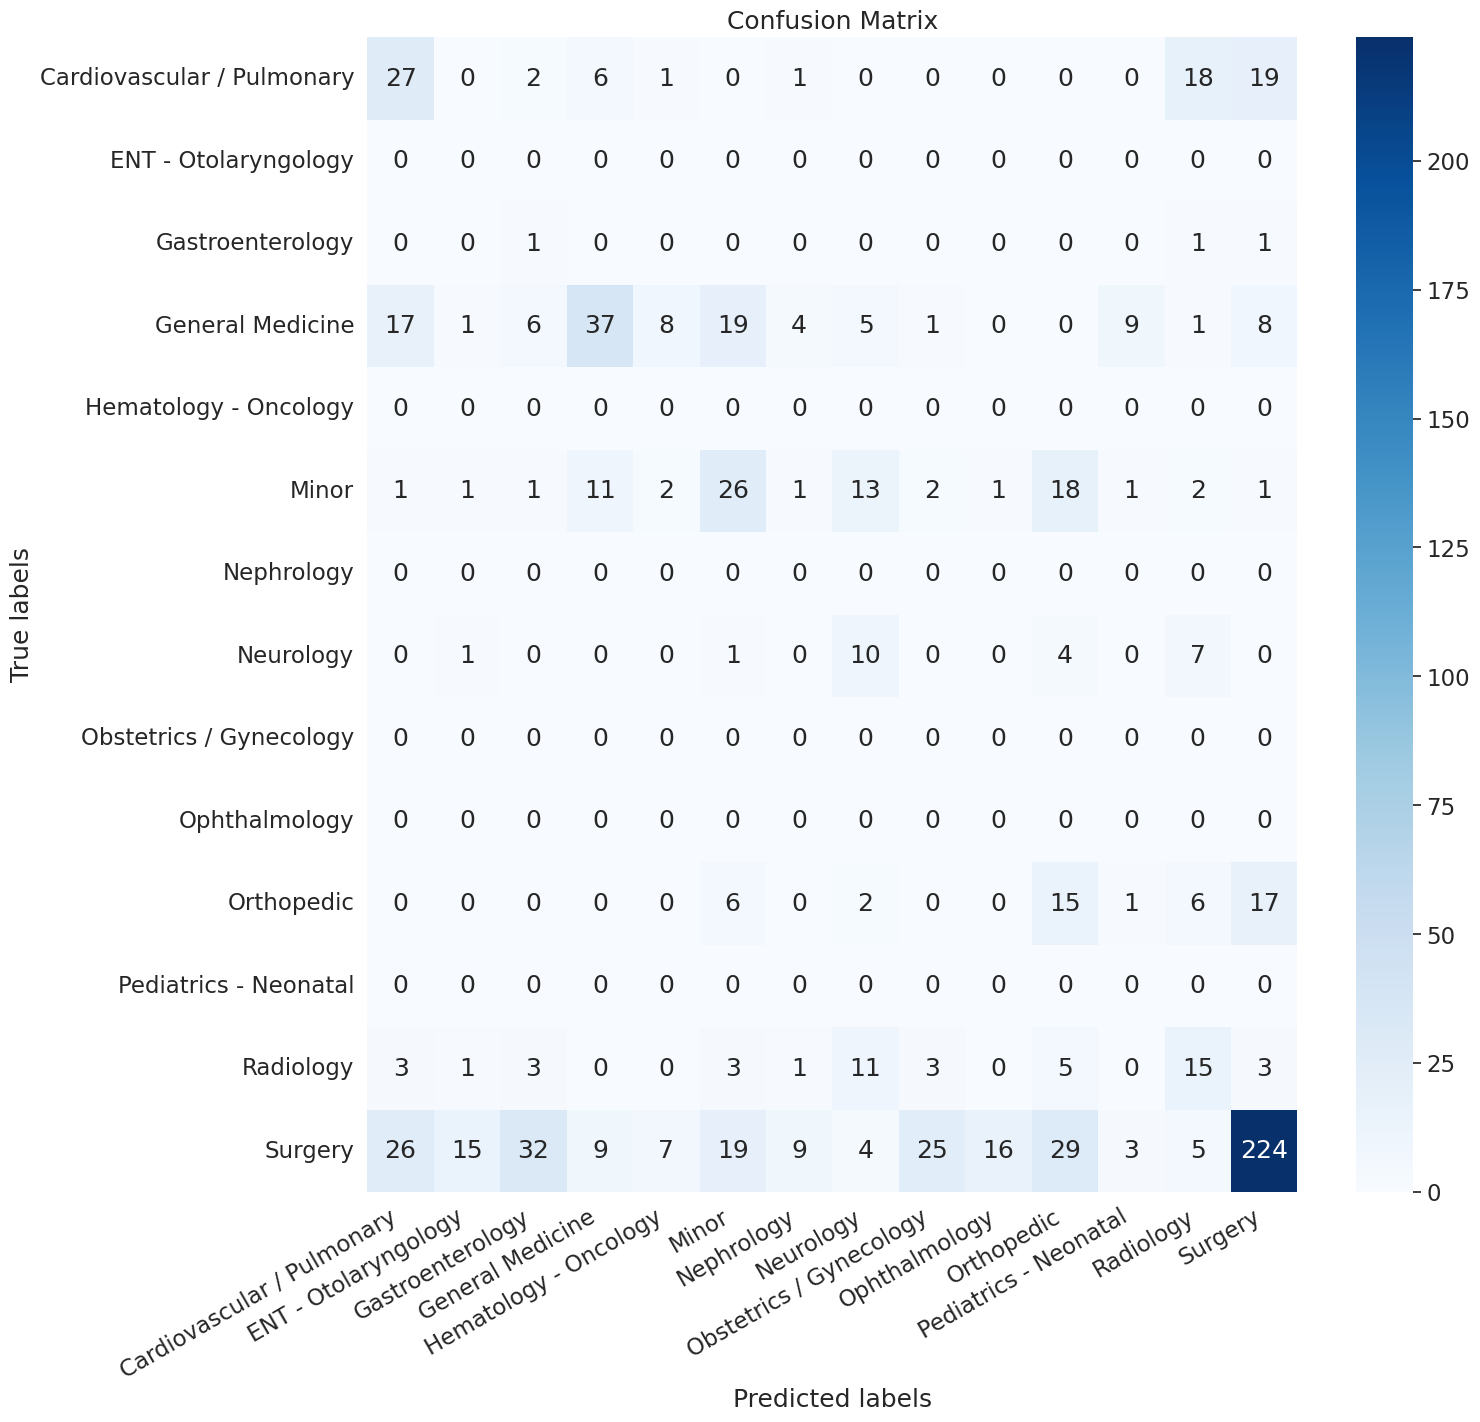

In [ ]:
fig = plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [ ]:
print(classification_report(test_labels, pred_labels, labels = category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.36      0.36      0.36        74
      ENT - Otolaryngology       0.00      0.00      0.00        19
          Gastroenterology       0.33      0.02      0.04        45
          General Medicine       0.32      0.59      0.41        63
     Hematology - Oncology       0.00      0.00      0.00        18
                     Minor       0.32      0.35      0.34        74
                Nephrology       0.00      0.00      0.00        16
                 Neurology       0.43      0.22      0.29        45
   Obstetrics / Gynecology       0.00      0.00      0.00        31
             Ophthalmology       0.00      0.00      0.00        17
                Orthopedic       0.32      0.21      0.25        71
     Pediatrics - Neonatal       0.00      0.00      0.00        14
                 Radiology       0.31      0.27      0.29        55
                   Surgery       0.53      0.82

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


In [ ]:
torch.save(model, "mt.pth")

In [ ]:
# Load model
loadmodel = torch.load("mt.pth")

In [ ]:
loadmodel.eval()

AttributeError: ignored

## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


TypeError: ignored

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
# drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/MyDrive/BERT/"

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model.from_pretrained(output_dir)
tokenizer = tokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)